<a href="https://colab.research.google.com/github/francji1/01PR/blob/main/R/Greg_Hamel_Intro_To_R/intro_to_r_part_23_confidence_intervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to R Part 23: Confidence Intervals

source:  https://www.kaggle.com/code/hamelg/intro-to-r-index/notebook


To this point, this guide has focused on the functions and syntax necessary to manipulate, explore and describe data in R. Data cleaning and exploratory analysis are often preliminary steps toward the end goal of extracting insight from data through statistical inference or predictive modeling. The remainder of this guide will focus on methods for analyzing data and tools for carrying out analyses in R.

[Statistical inference](https://en.wikipedia.org/wiki/Statistical_inference) is the process of analyzing sample data to gain insight into the population from which the data was collected and to investigate differences between data samples. In data analysis, we are often interested in the characteristics of some large population, but collecting data on the entire population may be infeasible. For example, leading up to U.S. presidential elections it could be very useful to know the political leanings of every single eligible voter, but surveying every voter is not feasible. Instead, we could poll some subset of the population, such as a thousand registered voters, and use that data to make inferences about the population as a whole.

## Point Estimates

[Point estimates](https://en.wikipedia.org/wiki/Point_estimation) are estimates of population parameters based on sample data. For instance, if we wanted to know the average age of registered voters in the U.S., we could take a survey of registered voters and then use the average age of the respondents as a point estimate of the average age of the population as a whole. The average of a sample is known as the sample mean.

The sample mean is usually not exactly the same as the population mean. This difference can be caused by many factors including poor survey design, biased sampling methods and the randomness inherent to drawing a sample from a population. Let's investigate point estimates by generating a population of random age data and then drawing a sample from it to estimate the mean.

In [1]:
set.seed(12)

# Generate a population
population_ages <- c(rexp(1000000,0.015)+18,   
                    rpois(500000,20)+18,
                    rpois(500000,32.5)+18,
                    rpois(500000,45)+18)

population_ages <- ifelse(population_ages<100, 
                          population_ages, population_ages%%100+18)


true_mean <- mean(population_ages)   # Check the population mean

true_mean

[1] 51.21884

In [ ]:
set.seed(10)

# Take a sample of 1000 ages
sample_ages <- sample(population_ages, size=1000)  

# Make a point estimate of the mean
sample_mean <- mean(sample_ages)            

sample_mean

# Check difference between estimate and population parameter
sample_mean-true_mean   

[1] 52.16361

[1] 0.9447717

Our point estimate based on a sample of 1000 individuals overestimates the true population mean by almost a year, but it is pretty close. This illustrates an important point: we can get a fairly accurate estimate of a large population by sampling a relatively small subset of individuals.

Another point estimate that may be of interest is the proportion of the population that belongs to some category or subgroup. For example, we might like to know the race of each voter we poll, to get a sense of the overall demographics of the voter base. You can make a point estimate of this sort of proportion by taking a sample and then checking the ratio in the sample.

In [ ]:
set.seed(12)

 # Generate some dummy demographic data
population_races <- c(rep("white",1000000), 
                      rep("hispanic",500000),
                      rep("black",500000),
                      rep("asian",250000),
                      rep("other",250000))

demographic_sample <- sample(population_races, size=1000)   # Take a sample

# Print the estimated proportion for each
for (race in unique(demographic_sample)){       
    print(paste(race," proportion estimate:"))       
    print(sum(demographic_sample==race)/1000)   
}

[1] "white  proportion estimate:"
[1] 0.4
[1] "asian  proportion estimate:"
[1] 0.096
[1] "other  proportion estimate:"
[1] 0.093
[1] "black  proportion estimate:"
[1] 0.207
[1] "hispanic  proportion estimate:"
[1] 0.204


*Note: The function unique() takes a vector and returns a new vector with duplicate elements removed.*

## Sampling Distributions and The Central Limit Theorem

Many statistical procedures assume that data follows a normal distribution, because the normal distribution has nice properties like symmetricity and having the majority of the data clustered within a few standard deviations of the mean. Unfortunately, real world data is often not normally distributed and the distribution of a sample tends to mirror the distribution of the population. This means a sample taken from a population with a skewed distribution will also tend to be skewed. Let's investigate by plotting the data and sample we created earlier and by checking the skew.

[1] 0.6556028

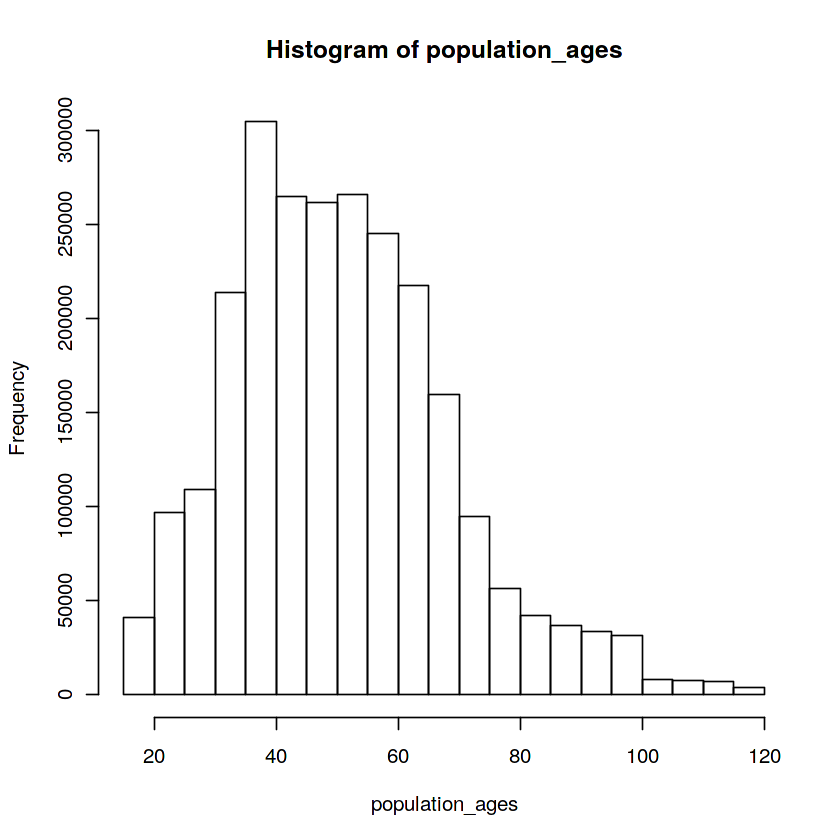

In [ ]:
library(e1071)

hist(population_ages, breaks=20)  # Create histogram of population

skewness(population_ages)         # Check the skewness

The histogram shows a distribution with right skew, which is confirmed by the skewness measurement of 0.6556. The sample we draw should have roughly the same shape and skewness.

[1] 0.6709607

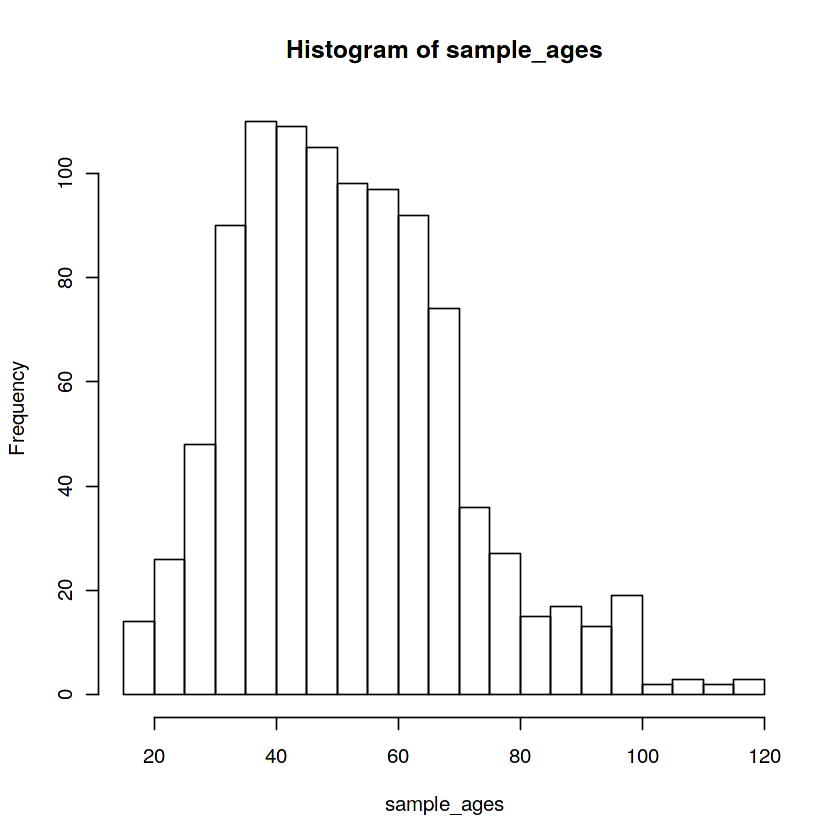

In [ ]:
hist(sample_ages, breaks=20)   # Create histogram of the sample

skewness(sample_ages)          # Check the skewness (point estimate of skewness)

The sample has roughly the same skew as the underlying population. This suggests that we can't apply techniques that assume a normal distribution to this data set. In reality, we can, thanks the central limit theorem.

The central limit theorem is one of the most important results of probability theory and serves as the foundation of many methods of statistical analysis. At a high level, the theorem states the distribution of many sample means, known as a sampling distribution, will be normally distributed. This rule holds even if the underlying distribution itself is not normally distributed. As a result we can treat our a sample mean as if it were drawn normal distribution.

To illustrate, let's create a sampling distribution by taking 200 samples from our population and then making 200 point estimates of the mean.

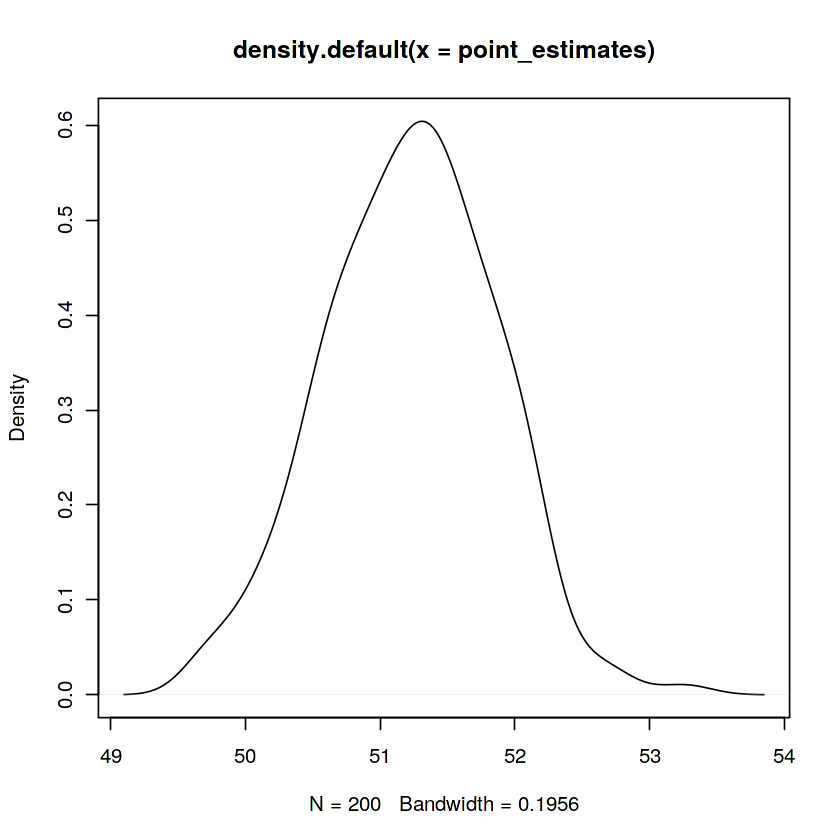

In [ ]:
set.seed(12)
point_estimates <- c()    # Create an empty vector to hold results

num_samples <- 200        # Initialize number of samples to take

 # Draw 200 samples and make 200 point estimates
for (x in 1:num_samples){         
    sample <- sample(population_ages, size=1000)
    point_estimates <- c(point_estimates, mean(sample))
}

plot(density(point_estimates))  # Plot the sampling distribution

The sampling distribution appears to be roughly normal, having significantly less skew than the original distribution:

In [ ]:
skewness(point_estimates)

[1] -0.01307386

In addition, the mean of the sampling distribution approaches the true population mean:

In [ ]:
mean(point_estimates)

mean(point_estimates)-true_mean    # Difference between true mean and sample means

[1] 51.22498

[1] 0.006137824

The more samples we take, the better our estimate of the population parameter is likely to be.

## Confidence Intervals

A point estimate can give you a rough idea of a population parameter like the mean, but estimates are prone to error and taking multiple samples to get improved estimates may not be feasible. A confidence interval is a range of values above and below a point estimate that captures the true population parameter at some predetermined confidence level. For example, if you want to have a 95% chance of capturing the true population parameter with a point estimate and a corresponding confidence interval, you'd set your confidence level to 95%. Higher confidence levels result in a wider confidence intervals.

Calculate a confidence interval by taking a point estimate and then adding and subtracting a margin of error to create a range. Margin of error is based on your desired confidence level, the spread of the data and the size of your sample. The way you calculate the margin of error depends on whether you know the standard deviation of the population or not.

If you know the standard deviation of the population, the margin of error is equal to: 

$$z * \frac{\sigma}{\sqrt{n}}$$

Where σ is the population standard deviation, n is sample size, and z is a number known as the z-critical value. The z-critical value is the number of standard deviations you'd have to go from the mean of the normal distribution to capture the proportion of the data associated with the desired confidence level. For instance, we know that roughly 95% of the data in a normal distribution lies within 2 standard deviations of the mean, so we could use 2 as the z-critical value for a 95% confidence interval (although it is more exact to get z-critical values with qnorm().).

Let's calculate a 95% confidence for our mean point estimate in R.

In [ ]:
set.seed(10)
sample_size <- 1000
sample_ages <- sample(population_ages, size=sample_size)  # Take a sample of 1000 ages

sample_mean <- mean(sample_ages)  # Get the sample mean

z_critical <- qnorm(0.975)        # Get the z-critical value*

print("z-critical value:")
print(z_critical)                 # Check the z-critical value

pop_stdev <- sd(population_ages)  # Get the population standard deviation

margin_of_error <- z_critical * (pop_stdev / sqrt(sample_size)) # Get margin of error

confidence_interval  <- c(sample_mean - margin_of_error,  # Calculate the the interval
                          sample_mean + margin_of_error)  

print("Confidence interval:")
print(confidence_interval   )     # Check the interval

[1] "z-critical value:"
[1] 1.959964
[1] "Confidence interval:"
[1] 51.05476 53.27245


*Note: We use qnorm(0.975) to get the desired z critical value instead of qnorm(0.95) because the distribution has two tails. Notice that the confidence interval we calculated captures the true population mean of 51.2188.*

Let's create several confidence intervals and plot them to get a better sense of what it means to "capture" the true mean.

In [ ]:
set.seed(12)
sample_size <- 1000

intervals <- c()  # Create and store 25 intervals
 
for (sample in 1:25){
sample_ages <- sample(population_ages, size=sample_size)  # Take a sample of 1000 ages

sample_mean <- mean(sample_ages)  # Get the sample mean

z_critical <- qnorm(0.975)        # Get the z-critical value*

pop_stdev <- sd(population_ages)  # Get the population standard deviation

margin_of_error <- z_critical * (pop_stdev / sqrt(sample_size)) # Calculate margin of error

confidence_interval  <- c(sample_mean - margin_of_error,  # Calculate the the interval
                          sample_mean + margin_of_error)  

intervals <- c(intervals, confidence_interval)    
}

interval_df <- data.frame(t(matrix(intervals,2,25)))  # Store intervals as data frame

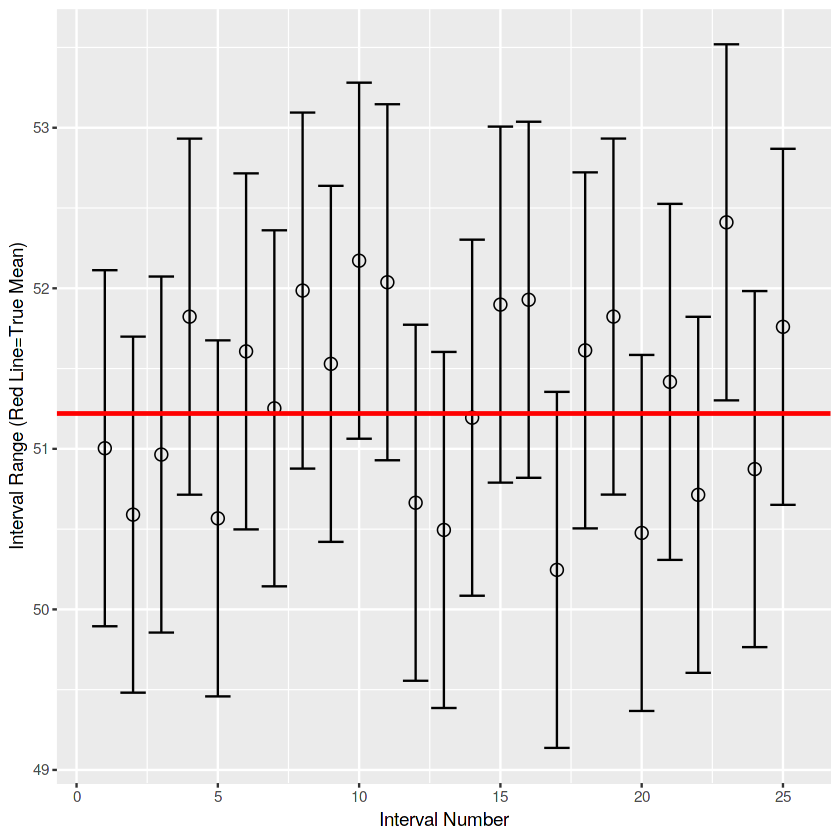

In [ ]:
library(ggplot2)


# Plot confidence intervals and show the true mean

my_plot <- ggplot(data=interval_df, aes(x=1:nrow(interval_df))) +
                geom_errorbar(aes(ymax = X2, ymin = X1)) +
                geom_point(aes(y=rowMeans(interval_df)), shape=1, size=3) +
                geom_abline(intercept=true_mean, slope=0,color="red",lwd=1) +
                ylab("Interval Range (Red Line=True Mean)") +
                xlab("Interval Number")

my_plot

Notice that in the plot above, all but one of the 95% confidence intervals overlap the red line marking the true mean. This is to be expected: since a 95% confidence interval captures the true mean 95% of the time, we'd expect our interval to miss the true mean 5% of the time.

If you don't know the standard deviation of the population, you have to use the standard deviation of your sample as a stand in when creating confidence intervals. Since the sample standard deviation may not match the population parameter the interval will have more error when you don't know the population standard deviation. To account for this error, we use what's known as a t-critical value instead of the z-critical value. The t-critical value is drawn from what's known as a t-distribution--a distribution that closely resembles the normal distribution but that gets wider and wider as the sample size falls. The t-distribution is built into R and has the nickname "t" so the functions for working with it are rt(), qt(), pt() and dt().

Let's take a new, smaller sample and then create a confidence interval without the population standard deviation, using the t-distribution.

In [ ]:
set.seed(12)
smaller_sample <- sample(population_ages, size=25)  

sample_mean <- mean(smaller_sample) # Get the sample mean

t_critical <- qt(0.975, df=24)      # Get the t-critical value *

print("t-critical value:")
print(t_critical)                   # Check the t-critical value

sample_stdev <- sd(smaller_sample)  # Get the sample standard deviation

margin_of_error <- t_critical * (sample_stdev / sqrt(25)) # Calculate margin of error

confidence_interval  <- c(sample_mean - margin_of_error,  # Calculate the the interval
                          sample_mean + margin_of_error) 

print("Confidence interval:")
print(confidence_interval)

[1] "t-critical value:"
[1] 2.063899
[1] "Confidence interval:"
[1] 43.0648 64.3763


*Note: when using the t-distribution, you have to supply the degrees of freedom (df). For this type of test, the degrees of freedom is equal to the sample size minus 1. If you have a large sample size, the t-distribution approaches the normal distribution.*

Notice that the t-critical value is larger than the z-critical value we used for 95% confidence interval. This allows the confidence interval to cast a larger net to make up for the variability caused by using the sample standard deviation in place of the population standard deviation. The end result is a much wider confidence interval (an interval with a larger margin of error.).

If you have a large sample, the t-critical value will approach the z-critical value so there is little difference between using the normal distribution vs. the t-distribution.

In [ ]:
# Check the difference between critical values with a sample size of 1000
qnorm(0.975)                
qt(0.975, df= 999)

[1] 1.959964

[1] 1.962341

Instead of calculating a confidence interval for a mean point estimate by hand, you can have R calculate it for you using the t.test() function.

In [ ]:
t.test(smaller_sample)


	One Sample t-test

data:  smaller_sample
t = 10.405, df = 24, p-value = 2.251e-10
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 43.0648 64.3763
sample estimates:
mean of x 
 53.72055 


Notice that the test output includes a 95% confidence interval that matches the result we calculated (we'll discuss t.test() in more detail in the next lesson).

We can also make a confidence interval for a point estimate of a population proportion. In this case, the margin of error equals:

$$z * \sqrt{\frac{p(1-p)}{n}}$$

Where z is the z-critical value for our confidence level, p is the point estimate of the population proportion and n is the sample size. Let's calculate a 95% confidence interval for Hispanics according to the sample proportion we calculated earlier (0.204).

In [ ]:
z_critical <- qnorm(0.975)    # Record z-critical value

p <- 0.204                    # Point estimate of proportion

n <- 1000                     # Sample size

margin_of_error <- z_critical * sqrt((p*(1-p))/n)

confidence_interval  <- c(p - margin_of_error,  # Calculate the the interval
                          p + margin_of_error) 

confidence_interval

[1] 0.1790242 0.2289758

Once again, the confidence interval captured the true population parameter of 0.2.

As with the confidence interval for the mean, you can use a built in R function to get a confidence interval for a population proportion instead of calculating it by hand. In this case, we use the prop.test() function.

In [ ]:
prop.test(x=204,      # Number of observations
          n=1000)     # Total number of samples


	1-sample proportions test with continuity correction

data:  204 out of 1000, null probability 0.5
X-squared = 349.28, df = 1, p-value < 2.2e-16
alternative hypothesis: true p is not equal to 0.5
95 percent confidence interval:
 0.1797036 0.2306071
sample estimates:
    p 
0.204 


In the output above, note that the 95% confidence interval listed roughly matches the one we calculated.

## Wrap Up

Estimating population parameters through sampling is a simple, yet powerful form of inference. Point estimates combined with error margins let us create confidence intervals that capture the true population parameter with high probability. R's built in probability distribution and test functions make it easy to calculate confidence intervals quickly.

Next time we'll expand on the concepts in this lesson by learning about statistical hypothesis testing and the t-test.

## Next Lesson: [Intro to R Part 24: Hypothesis Testing](https://www.kaggle.com/hamelg/intro-to-r-part-24-hypothesis-testing)
[back to index](https://www.kaggle.com/hamelg/intro-to-r-index)

## Exercises

To do the exercises, fork this notebook and then fill in and run the code boxes according to the exercise instructions.

### Exercise #1
Load the Titanic data set and make a point estimate for the population mean of the Age column by taking a sample of 40 passengers. Then calculate the difference between your sample mean and the true mean. Remember to include the argument na.rm = TRUE when using the mean() function on Age to ignore NA values.

In [ ]:
set.seed(12)
titanic_train <- read.csv("../input/train.csv")

age_sample <- "Your Code Here"

point_estimate <- "Your Code Here"

#Print sample mean
print("Point Estimate")
print(point_estimate)

# Print difference between sample mean and true mean
print("Mean Difference")
print("Your Code Here")

[1] "Point Estimate"
[1] "Your Code Here"
[1] "Mean Difference"
[1] "Your Code Here"


### Exercise #2
Calculate the margin of error for the point estimate for a 95% confidence interval. Use the t distribution. Note that since NA values were removed in calculating the point estimate the sample size is actually 40 minus the number of NA values in the sample.

In [ ]:
true_sample_size <- 40 - "Your Code Here"

t_critical <- qt("Your Code Here", df = true_sample_size)

margin_of_error <- t_critical * "Your Code Here"

print("Margin of Error")
print(margin_of_error)

ERROR: Error in 40 - "Your Code Here": non-numeric argument to binary operator


### Exercise #3
Calculate and print a 95% confidence interval for the mean of age using the point estimate and margin of error you calculated above. Make sure that your confidence interval match the one produced by the call to t.test(age_sample).

In [ ]:
print("Confidence Interval")
print(c("Your Code Here!",
        "Your Code Here!"))


t.test(age_sample)

[1] "Confidence Interval"
[1] "Your Code Here!" "Your Code Here!"


Warning message in mean.default(x):
“argument is not numeric or logical: returning NA”Warning message in var(x):
“NAs introduced by coercion”

ERROR: Error in t.test.default(age_sample): not enough 'x' observations


## Exercise Solutions

In [ ]:
# 1 

set.seed(12)
titanic_train <- read.csv("../input/train.csv")

age_sample <- sample(titanic_train$Age, 40)

point_estimate <- mean(age_sample, na.rm=TRUE)

#Print sample mean
print("Point Estimate")
print(point_estimate)

# Print difference between sample mean and true mean
print("Mean Difference")
print(mean(titanic_train$Age, na.rm=TRUE) - point_estimate)


# 2 

t_critical <- qt(0.975, df = 31)

margin_of_error <- t_critical * (sd(age_sample, na.rm=T) / sqrt(32))

print("Margin of Error")
print(margin_of_error)

# 3

print("Confidence Interval")
print(c(point_estimate-margin_of_error,
       point_estimate+margin_of_error))


t.test(age_sample)

[1] "Point Estimate"
[1] 30.84375
[1] "Mean Difference"
[1] -1.144632
[1] "Margin of Error"
[1] 4.396747
[1] "Confidence Interval"
[1] 26.4470 35.2405



	One Sample t-test

data:  age_sample
t = 14.307, df = 31, p-value = 3.356e-15
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 26.4470 35.2405
sample estimates:
mean of x 
 30.84375 
